In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/avazu-ctr-prediction/sampleSubmission.gz
/kaggle/input/avazu-ctr-prediction/train.gz
/kaggle/input/avazu-ctr-prediction/test.gz


In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import random
import gzip
import category_encoders as ce
pd.options.display.float_format = '{:.2f}'.format

In [9]:
# Reading the input data

num_records = 40428967
sample_size = 5000000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
# Parse 'hour' column as datetime
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
# Read csv
df = pd.read_csv("../input/avazu-ctr-prediction/train.gz", parse_dates=['hour'], date_parser=parse_date,\
                     skiprows=skip_values)
# Head
df.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000169349117863715,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
1,10001868339616595934,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,17747,320,50,1974,2,39,100019,33


In [10]:
df.shape

(5000000, 24)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 24 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                uint64        
 1   click             int64         
 2   hour              datetime64[ns]
 3   C1                int64         
 4   banner_pos        int64         
 5   site_id           object        
 6   site_domain       object        
 7   site_category     object        
 8   app_id            object        
 9   app_domain        object        
 10  app_category      object        
 11  device_id         object        
 12  device_ip         object        
 13  device_model      object        
 14  device_type       int64         
 15  device_conn_type  int64         
 16  C14               int64         
 17  C15               int64         
 18  C16               int64         
 19  C17               int64         
 20  C18               int64         
 21  C19     

In [12]:
df.isna().sum() # Checking any null values

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

In [13]:
# hour column contains event date with all the details, extracting the same to create different columns.

df['month'] = df['hour'].dt.month
df['dayofweek'] = df['hour'].dt.dayofweek
df['day'] = df['hour'].dt.day
df['hour_time'] = df['hour'].dt.hour

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5000000.00,9225957099146027008.00,5326343500012931072.00,521159373627.00,4614779139009448960.00,9228254025794883584.00,13840308352812081152.00,18446743972517787648.00
click,5000000.00,0.17,0.38,0.00,0.00,0.00,0.00,1.00
C1,5000000.00,1004.97,1.09,1001.00,1005.00,1005.00,1005.00,1012.00
banner_pos,5000000.00,0.29,0.51,0.00,0.00,0.00,1.00,7.00
device_type,5000000.00,1.02,0.53,0.00,1.00,1.00,1.00,5.00
device_conn_type,5000000.00,0.33,0.85,0.00,0.00,0.00,0.00,5.00
C14,5000000.00,18841.32,4959.22,375.00,16920.00,20346.00,21894.00,24052.00
C15,5000000.00,318.88,21.19,120.00,320.00,320.00,320.00,1024.00
C16,5000000.00,60.09,47.30,20.00,50.00,50.00,50.00,1024.00
C17,5000000.00,2112.49,609.36,112.00,1863.00,2323.00,2526.00,2758.00


* **C15, C16,C19,C21 are having outliers**

In [15]:
df['C15'].quantile(0.98)

320.0

In [17]:
0.5 *df['C15'].max()

512.0

In [18]:
# Dealing with outliers by capping

cols = ['C15', 'C16', 'C19', 'C21']
for col in cols:
    percentiles = df[col].quantile(0.98)
    if df[col].quantile(0.98) < 0.5 * df[col].max():
        df[col][df[col] >= percentiles] = percentiles

In [19]:
# segrigating numerical and categorical variables.

numerical = []
categorical = []

for col in (df.columns):
    if df[col].dtype == "object":
        categorical.append(col)
    else:
        numerical.append(col)
print("numerical columns = ",numerical)
print("\ncategorical columns = ",categorical)

numerical columns =  ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek', 'day', 'hour_time']

categorical columns =  ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


0    4151214
1     848786
Name: click, dtype: int64


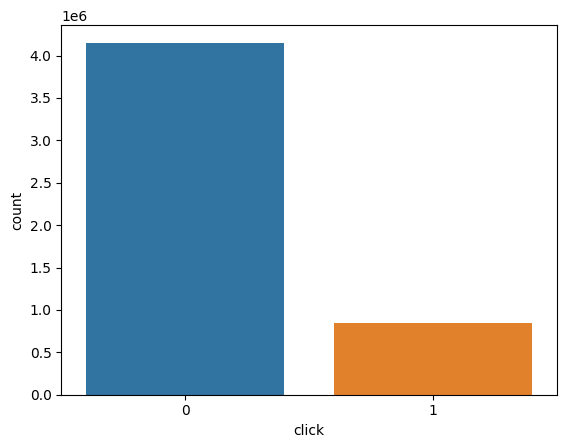

In [23]:
print(df['click'].value_counts())
sns.countplot(x='click',data=df)
plt.show();

* **The target column is highly imbalance**

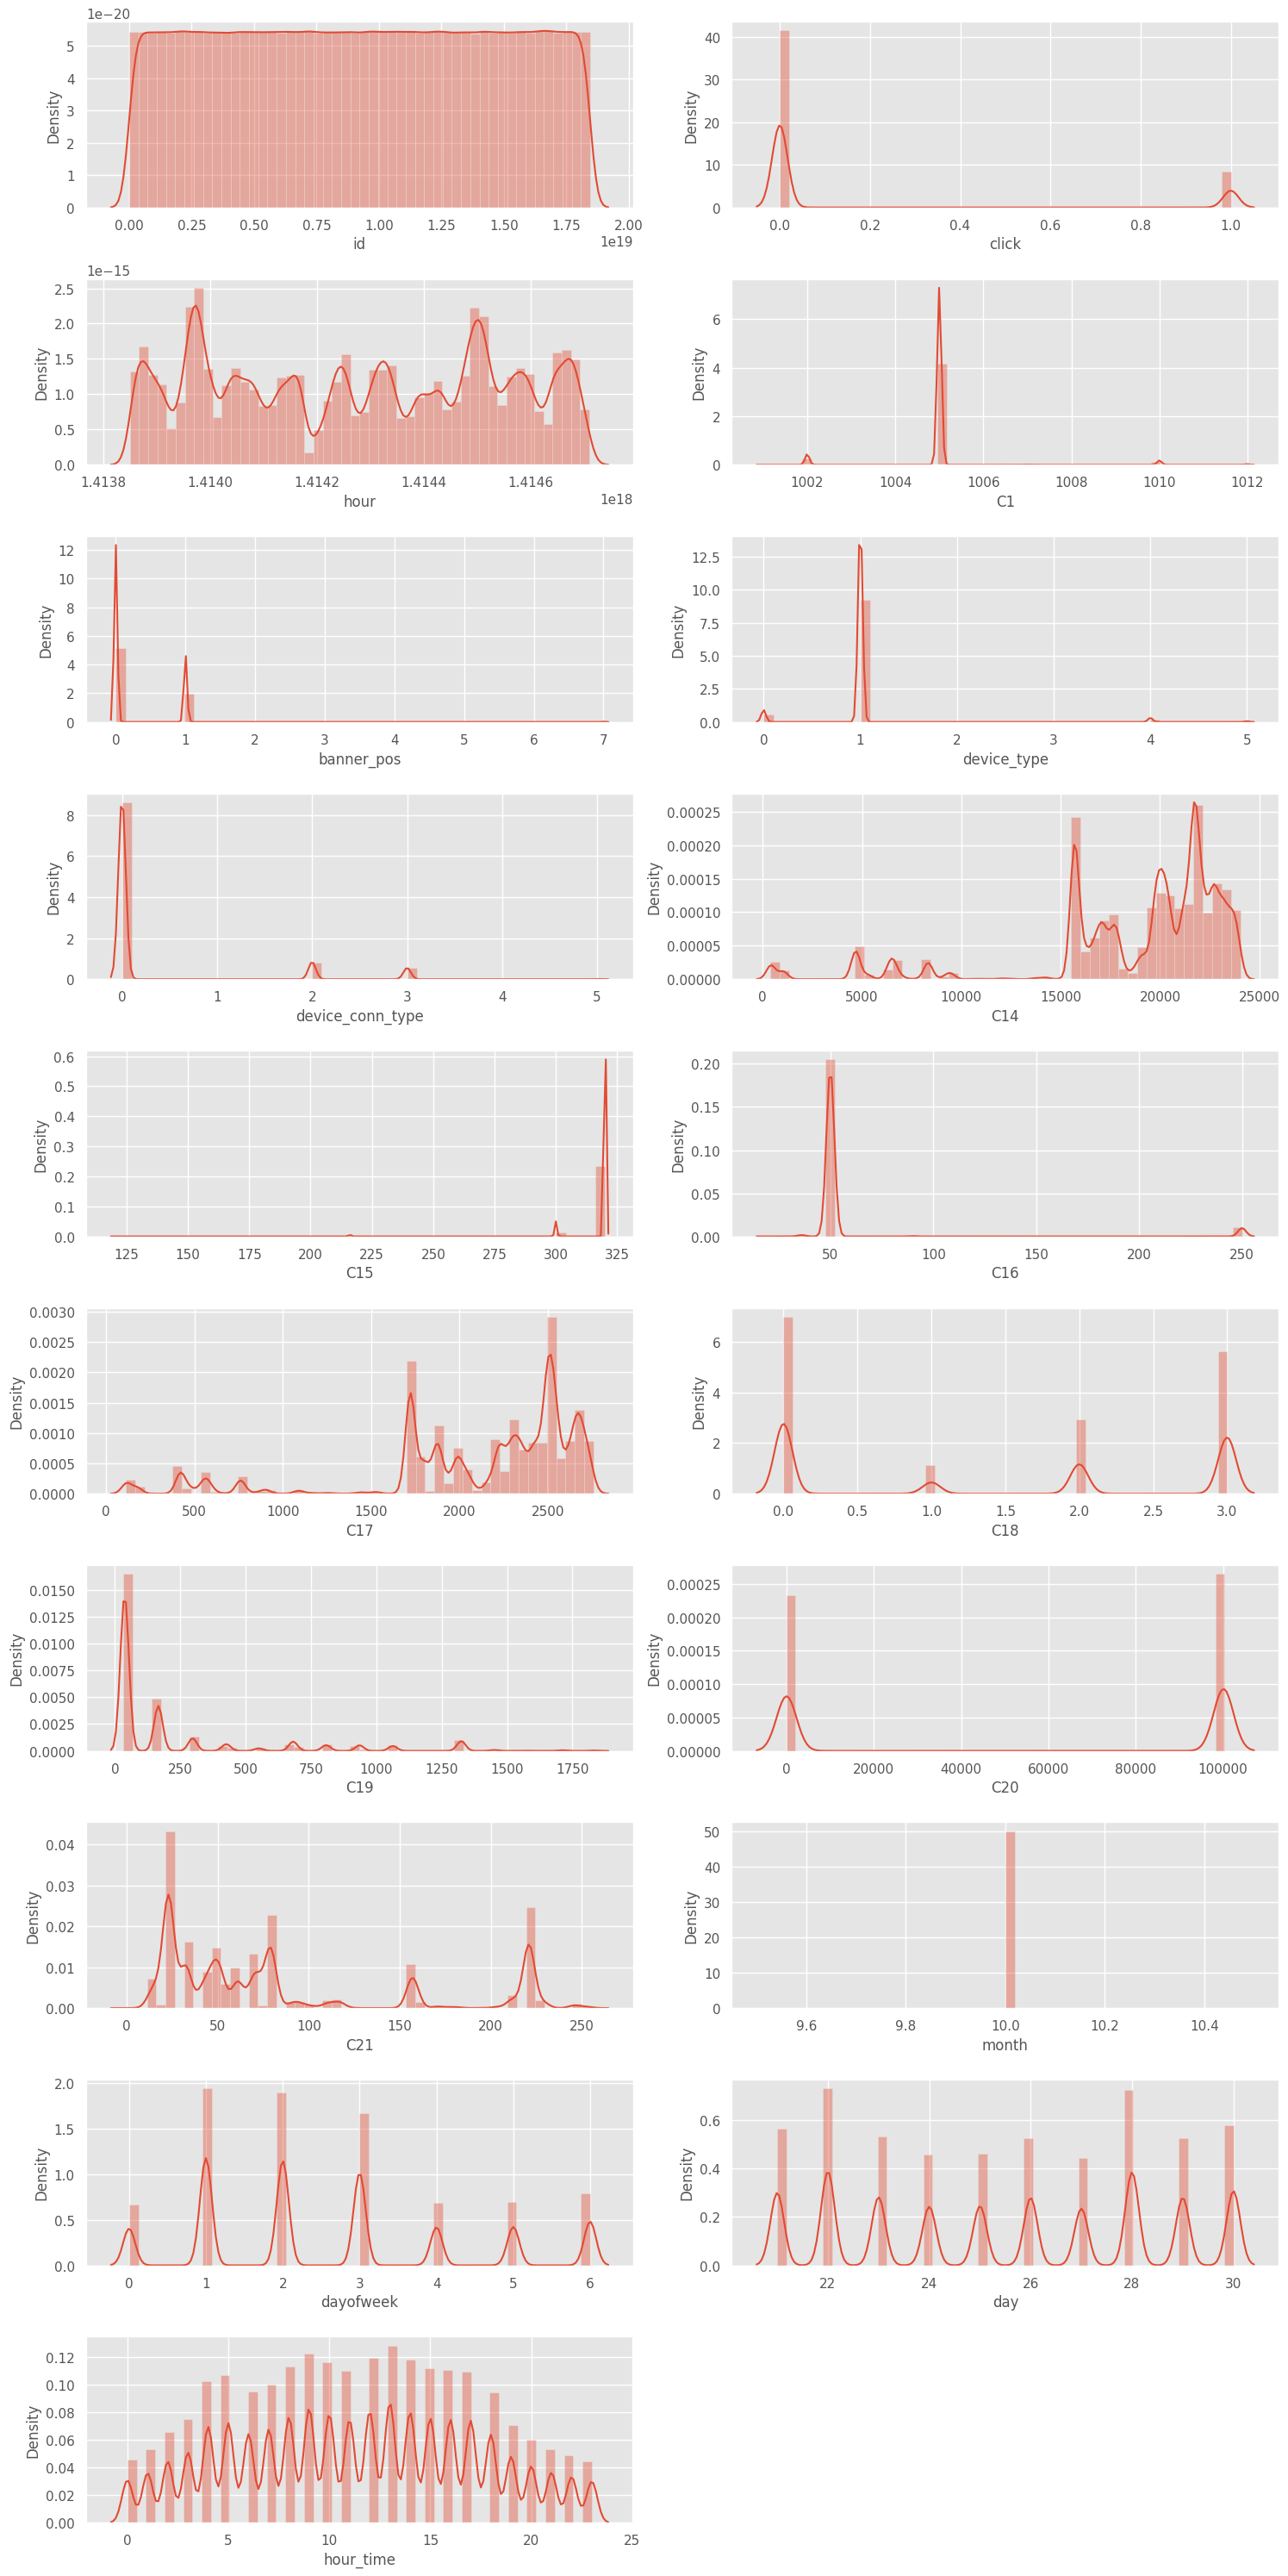

In [37]:
# The code below will plot histograms for all numerical columns 
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', 0)
plt.style.use('ggplot')

n = 2
plt.figure(figsize=[15,3*math.ceil(len(numerical)/n)])

for i in range(len(numerical)):
    plt.subplot(math.ceil(len(numerical)/n),n,i+1)
    sns.distplot(df[numerical[i]])

plt.tight_layout()
plt.show()

Text(0.5, 1.05, 'Pearson correlation of Features')

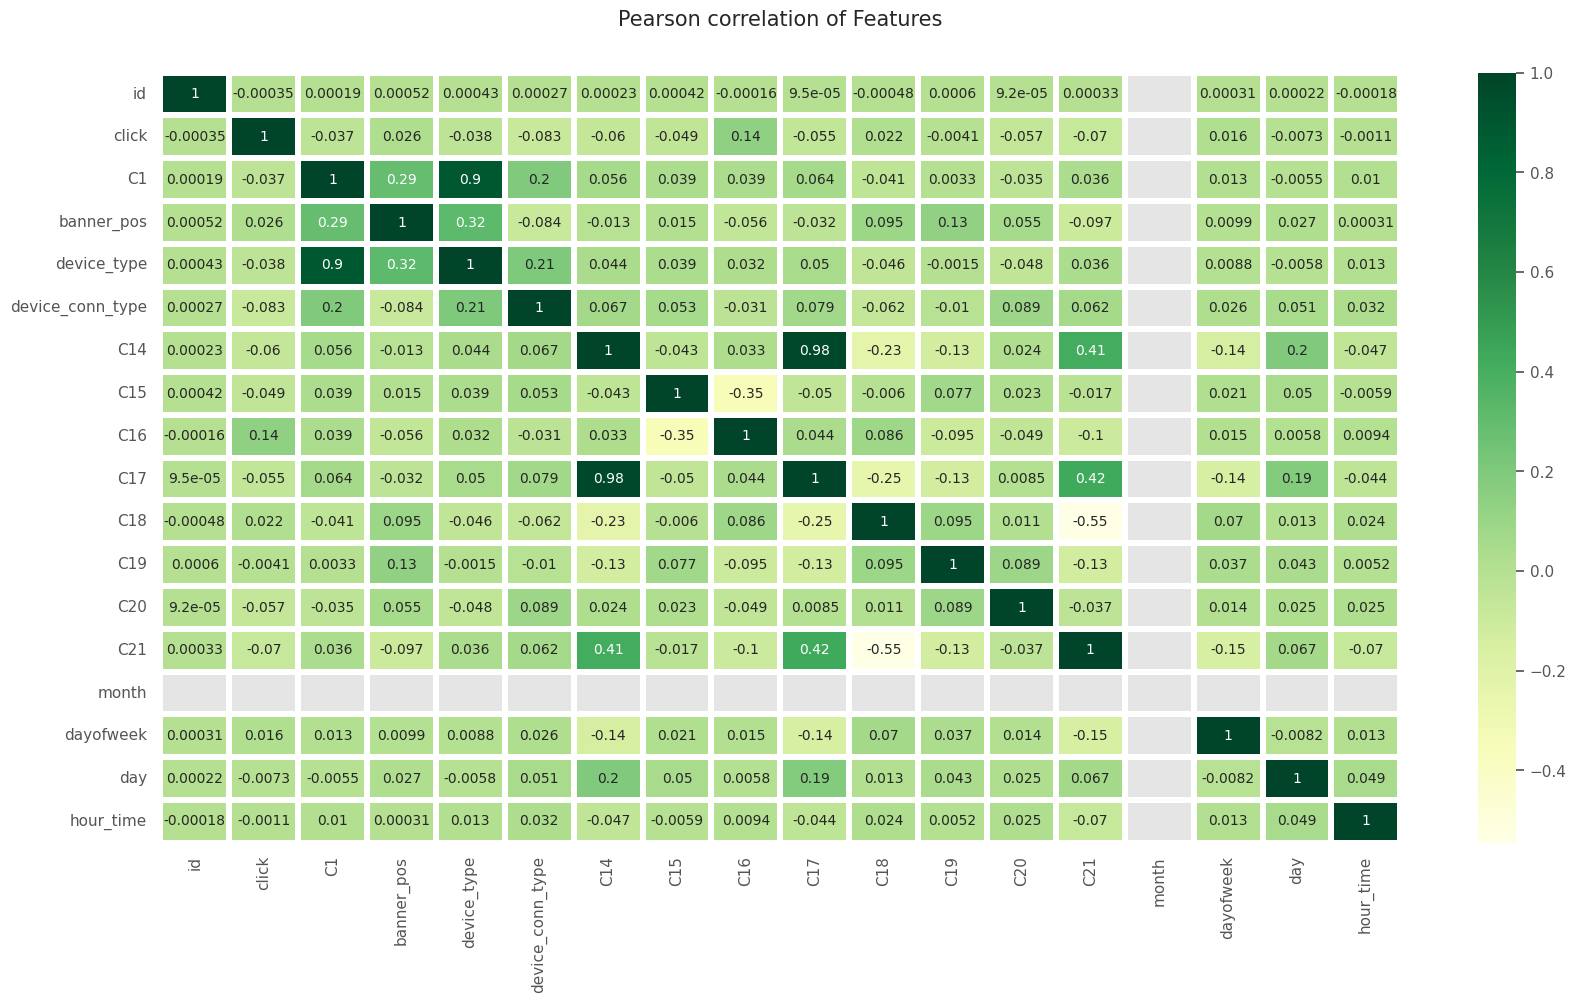

In [38]:
# Pearson correlation table to find the relationship with output with all input features. 

corr =df.corr()
f, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corr, ax=ax, annot=True,linewidths=3,cmap='YlGn')
plt.title("Pearson correlation of Features", y=1.05, size=15)

* **'id','hour','month','C20' will be dropped**

In [40]:
df.drop(['id','hour','month','C20'],axis=1,inplace=True)

In [42]:
# Take sample data of 10%
sample_data = df.sample(frac=0.1,random_state=42)

In [44]:
#Independent and Dependent features
X = sample_data.drop(['click'],axis=1)
y = sample_data['click']

In [45]:
# Target encoding
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X,y)
X.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour_time
3577888,1005,0,0.20,0.20,0.21,0.20,0.19,0.20,0.17,0.25,0.18,1,0,23192,320,50,2671,0,163,221,1,28,10
4993932,1005,0,0.12,0.12,0.13,0.14,0.14,0.11,0.15,0.15,0.27,1,0,23997,320,50,2748,0,35,79,3,30,23


In [47]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)

In [48]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    return acc, f1, precision, recall

In [49]:
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train)  # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision, model_train_recall = evaluate_clf(y_train, y_train_pred)

        # Test set performance
        model_test_accuracy, model_test_f1, model_test_precision, model_test_recall = evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1))
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        accuracy_list.append(model_test_accuracy)
        print('='*35)
        print('\n')
        
    report = pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=["Accuracy"])
        
    return report

In [51]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier()
}

In [52]:
result = evaluate_models(X,y,models)

Random Forest
Model performance for Training set
- Accuracy: 0.9970
- F1 score: 0.9910
- Precision: 0.9949
- Recall: 0.9871
----------------------------------
Model performance for Test set
- Accuracy: 0.9313
- F1 score: 0.7790
- Precision: 0.8523
- Recall: 0.7173


Decision Tree
Model performance for Training set
- Accuracy: 0.9970
- F1 score: 0.9910
- Precision: 0.9991
- Recall: 0.9829
----------------------------------
Model performance for Test set
- Accuracy: 0.9154
- F1 score: 0.7509
- Precision: 0.7470
- Recall: 0.7548


Logistic Regression
Model performance for Training set
- Accuracy: 0.8308
- F1 score: 0.0000
- Precision: 0.0000
- Recall: 0.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8311
- F1 score: 0.0000
- Precision: 0.0000
- Recall: 0.0000


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.8973
- F1 score: 0.6184
- Precision: 0.8332
- Recall: 0.4917
----------------------------------
Model performance for Tes

In [53]:
result

,Model Name,Accuracy
2,Logistic Regression,0.83
3,K-Neighbors Classifier,0.86
1,Decision Tree,0.92
0,Random Forest,0.93
